**TO-DO**
- **DONE**: Post stratify on location (Eva)
    - Means we have more combinations we need to make predictions for -> 1800 which matches the census
    - Also going to change the way we weight by census
        - region -> column
- **DONE**: Plot regional distribution of census data and compare to our distribution (Eva)
    - one for our survey
    - one for census
    - height of bar is percentage
    - one plot two bars per regions (one ours, one census)
- **DONE**: Output results to CSV (Eva)
    - Unweighted
    - Weighted
- Write report

We've received some questions about what to do with the post-stratified attitudes obtained in Step 5 of Assignment 3. Please upload a .csv file clearly tabulating your results, along with the code you used. For the report, please give a brief low-dimensional summary or visualization of how weight moved before and after post-stratification, e.g., what census regions gained/lost weight, summing over the finer granularities.

In [1]:
import pandas as pd
import numpy as np
import itertools
import json
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from typing import List, Tuple

In [2]:
LogisticRegressionType = sklearn.linear_model._logistic.LogisticRegression
LabelEncoderType = sklearn.preprocessing._label.LabelEncoder
EncoderType = sklearn.pipeline.Pipeline

REGION_COLUMNS = ['New England',
                  'Middle Atlantic',
                  'East North Central',
                  'West North Central',
                  'South Atlantic',
                  'East South Central',
                  'West South Central',
                  'Mountain',
                  'Pacific']

In [3]:
# Read in census data
f = open('census_data.json')
census_data = json.load(f)
census_data = [sublist[:-1] for sublist in census_data]
census_df = pd.DataFrame(census_data)
census_df = census_df.transpose()
column = ['Demographics']
column.extend(REGION_COLUMNS)
census_df.columns = column
f.close()

In [4]:
# Map census categories to survey categories
s_to_c_mappings = {
    'Gender': {'Male': '1', 'Female': '2'},
    'Age': {'> 60': '1', '45-60': '2', '30-44': '3', '18-29': '4'},
    'Household Income': {'$150,000+': '1', '$100,000 - $149,999': '2', '$50,000 - $99,999': '3', '$25,000 - $49,999': '4', '$0 - $24,999': '5'},
    'Education': {'Graduate degree': '1', 'Bachelor degree': '2', 'Some college or Associate degree': '3', 'High school degree': '4', 'Less than high school degree': '5'}
}

In [5]:
# Combine survey data
og_survey_df = pd.read_csv('comma-survey.csv', index_col='RespondentID')
new_survey_df = pd.read_csv('new_comma_survey.csv', index_col='RespondentID')
survey_df = pd.concat([og_survey_df, new_survey_df])

In [6]:
# Extract question and demographics column names
question_cols = list(survey_df.columns)[:7]
demographic_cols = list(survey_df.columns)[7:]

In [7]:
# Drop rows where at least one of the sbustansive questions were not answered
survey_df = survey_df.dropna(axis=0, subset=question_cols)
# Drop rows where all the demographic questions were unanswered
survey_df = survey_df.dropna(axis=0, how='all', subset=demographic_cols)

In [8]:
# Encode demographic responses
demographics = survey_df[demographic_cols].to_numpy()
# Define the ordinal features pipeline
enc = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', missing_values=np.nan, add_indicator=True)),
    ('encoder', OneHotEncoder())
])
enc.fit(demographics)
X_demographics = enc.transform(demographics)

In [9]:
# Fit label encoders
labelEncoders = [LabelEncoder() for i in range(len(question_cols))]
for idx, q in enumerate(question_cols):
    y_vals = survey_df[q].to_numpy()
    labelEncoders[idx].fit(y_vals)

In [10]:
# Fit models
models = [LogisticRegression(multi_class='multinomial', max_iter=1000, fit_intercept=False) for i in range(len(question_cols))]
for idx, q in enumerate(question_cols):
    y_vals = survey_df[q].to_numpy()
    Y_vals = labelEncoders[idx].transform(y_vals)
    model = models[idx].fit(X_demographics, Y_vals)

In [11]:
# Create all demographic combinations, dropping nans
demographic_options = []
for d in demographic_cols:
    demographic_options.append(survey_df[d].unique())
unique_combinations = list(itertools.product(*demographic_options))
unique_combinations = [i for i in unique_combinations if np.nan not in i]

In [12]:
# Create dictionary of Questions and Answers
qidx_answers = {}
for q_idx in range(len(question_cols)):
    qidx_answers[q_idx] = list(labelEncoders[q_idx].classes_)

In [13]:
# Create dictionaries of running sums
unweighted_running_sums = {}
weighted_running_sums = {}
for q_idx in range(len(question_cols)):
    unweighted_running_sums[q_idx] = {}
    weighted_running_sums[q_idx] = {}
    for a_idx in range(len(qidx_answers[q_idx])):
        unweighted_running_sums[q_idx][a_idx] = 0.0
        weighted_running_sums[q_idx][a_idx] = 0.0

# Calculate the predicted outcome
total_population = 0
total_combos = len(unique_combinations)
for combo in unique_combinations:
    # Get the corresponding count from Census data
    gender, age, income, education, region = combo
    x_vals = enc.transform([combo])
    census_mapping = {
        'SEX': s_to_c_mappings['Gender'][gender],
        'AGEP_RC2': s_to_c_mappings['Age'][age],
        'SCHL_RC2': s_to_c_mappings['Household Income'][income],
        'HINCP_RC2': s_to_c_mappings['Education'][education]
    }
    deographic_total = census_df[region].loc[census_df['Demographics'] == census_mapping].values[0]
    total_population += deographic_total
    # For every substansive question
    for q_idx in range(len(question_cols)):
        # Get the probability predictions
        y_prob = models[q_idx].predict_proba(x_vals)[0]
        for a_idx in range(len(y_prob)):
            unweighted_running_sums[q_idx][a_idx] += y_prob[a_idx] / total_combos
            weighted_running_sums[q_idx][a_idx] += y_prob[a_idx] * deographic_total

In [14]:
# Save results to a CSV
results = []
for q_idx in range(len(question_cols)):
    for a_idx in range(len(qidx_answers[q_idx])):
        results.append({
            'Question': question_cols[q_idx],
            'Answer': qidx_answers[q_idx][a_idx],
            'Unweighted Probability': round(unweighted_running_sums[q_idx][a_idx], 7),
            'Weighted Probability': round(weighted_running_sums[q_idx][a_idx]/ total_population, 7)
        })
results_df = pd.DataFrame.from_records(results)
results_df.to_csv('survey_poststrat_results.csv')

In [15]:
tot_pop_for_percent = total_population / 100
for q_idx in range(len(question_cols)):
    print('Q{}:'.format(q_idx), question_cols[q_idx])
    for a_idx in range(len(qidx_answers[q_idx])):
        print('{}:\t unweighted:'.format(qidx_answers[q_idx][a_idx]), '{:,.2%}'.format(unweighted_running_sums[q_idx][a_idx]),
             '\tweighted:', '{:,.2%}'.format(weighted_running_sums[q_idx][a_idx]/ total_population))
    print()

Q0: In your opinion, which sentence is more gramatically correct?
It's important for a person to be honest, kind and loyal.:	 unweighted: 42.87% 	weighted: 44.79%
It's important for a person to be honest, kind, and loyal.:	 unweighted: 57.13% 	weighted: 55.21%

Q1: Prior to reading about it above, had you heard of the serial (or Oxford) comma?
No:	 unweighted: 46.92% 	weighted: 46.61%
Yes:	 unweighted: 53.08% 	weighted: 53.39%

Q2: How much, if at all, do you care about the use (or lack thereof) of the serial (or Oxford) comma in grammar?
A lot:	 unweighted: 28.60% 	weighted: 26.17%
Not at all:	 unweighted: 13.20% 	weighted: 12.61%
Not much:	 unweighted: 25.16% 	weighted: 25.18%
Some:	 unweighted: 33.04% 	weighted: 36.04%

Q3: How would you write the following sentence?
Some experts say it's important to drink milk, but the data are inconclusive.:	 unweighted: 19.39% 	weighted: 18.69%
Some experts say it's important to drink milk, but the data is inconclusive.:	 unweighted: 80.61% 	wei

<AxesSubplot:title={'center':'Population Distribution Across Regions'}, xlabel='Region', ylabel='Percentage Total Population'>

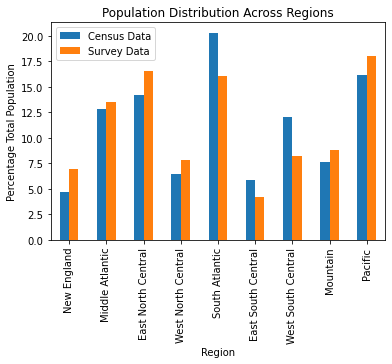

In [16]:
# Plot regional distribution of census data and compare to our distribution
x_vals = REGION_COLUMNS
census_distribution = census_df[REGION_COLUMNS].sum(axis=0).div(total_population).mul(100)
census_distribution.name = 'Census Data'
our_distribution = survey_df.iloc[:,11].value_counts(normalize=True, sort=False).mul(100)
our_distribution.name = 'Survey Data'
regional_distribs = pd.concat([census_distribution, our_distribution], axis=1)
regional_distribs.plot.bar(title="Population Distribution Across Regions", ylabel="Percentage Total Population", xlabel="Region")